In [1]:
%matplotlib inline
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools

# Notes on classifying images

First, read in some test data, then we'll create an average image and an average background residual, the difference between all pairs of background images.

In [2]:
img1 = mpimg.imread('test_data/image1.png')
img2 = mpimg.imread('test_data/image2.png')
img3 = mpimg.imread('test_data/image3.png')
img4 = mpimg.imread('test_data/image4.png')
img5 = mpimg.imread('test_data/image5.png')
images = [img1, img2, img3, img4, img5]
signal = mpimg.imread("test_data/image_signal.png")

average_image = (img1 + img2 + img3 + img4 + img5)/5.

average_background_res = np.zeros(images[0].shape)
for n, img in enumerate(images):
    average_background_res += np.abs(img - average_image)
average_background_res = average_background_res / len(images)

Okay, now let's have a look at the images

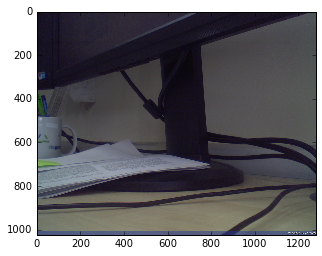

In [3]:
plt.imshow(average_image)

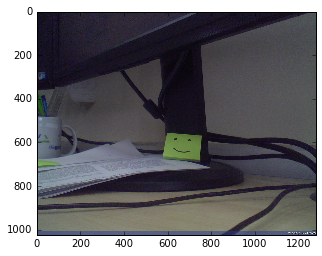

In [4]:
plt.imshow(signal)

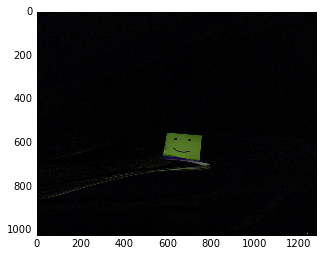

In [5]:
res_with_signal = np.abs(signal - average_image)
imgplot = plt.imshow(res_with_signal)

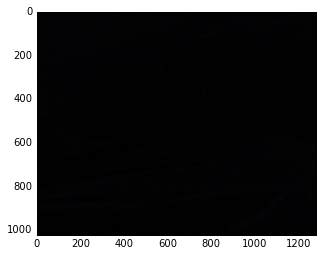

In [6]:
plt.imshow(average_background_res)

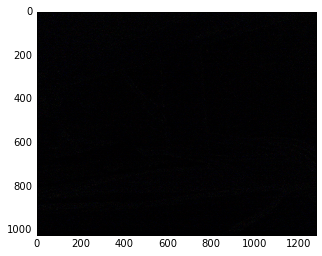

In [7]:
res_without_signal = np.abs(img2 - average_image)
imgplot = plt.imshow(res_without_signal)

## Classify the background

Now we will look at the distribution of residuals

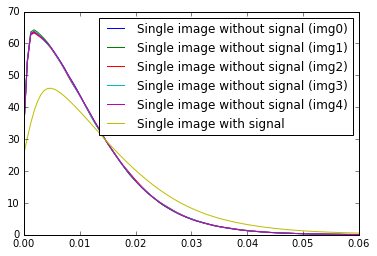

In [9]:
xvals = np.linspace(0, 0.06, 100)

for n, img in enumerate(images):
    Rchannel_without = np.abs(img - average_image)[:, :, 0].flatten()
    plt.plot(xvals, scipy.stats.gaussian_kde(Rchannel_without).evaluate(xvals),
             label="Single image without signal (img{})".format(n))

Rchannel_with = res_with_signal[:, :, 0].flatten()
plt.plot(xvals, scipy.stats.gaussian_kde(Rchannel_with).evaluate(xvals),
         label="Single image with signal")

plt.legend()

We see that for each of the images *without* a signal the background is similar, but the image *with* a signal has a quite different distribution. Now we need to determine how to test for this. 

## Simple test using the CDF:

A notable feature of the signal posterior is the heavier tail: this is exactly caused by the existence of the signal. To get a feel for this let's look at the CDF

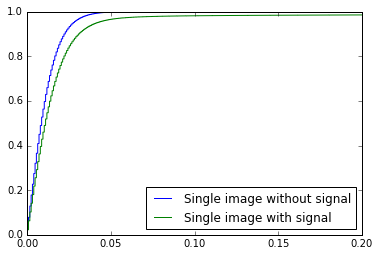

In [25]:
def ECDF(data):
    sorted = np.sort(data)
    yvals = np.arange(len(sorted))/float(len(sorted))
    return sorted, yvals

plt.plot(*ECDF(Rchannel_without), label="Single image without signal")
plt.plot(*ECDF(Rchannel_with), label="Single image with signal")
plt.legend(loc=4)
plt.xlim(0, 0.2)
plt.show()

So a reasonable test of a signal might be to look at a point where the background CDF is $\sim 1$, then if the CDF of the new image is less than some threshold, it contains a signal.

## KS-test

Another alternatibe might be to use the KS - test against the average residual

In [ ]:
fits = []
for img in images[:2]:
    res = np.abs(img - average_image)
    fits.append(scipy.stats.gamma.fit(res))

(0.125, 0)

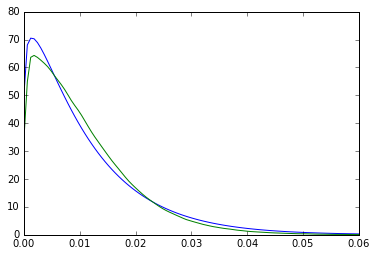

In [17]:
fit_vals = np.mean(fits, axis=0)


plt.plot(xvals, scipy.stats.gamma.pdf(xvals, *fit_vals))

plt.plot(xvals, scipy.stats.gaussian_kde(Rchannel_without).evaluate(xvals),
         label="Single image without signal")

def gamma_cdf(x):
    return scipy.stats.gamma.cdf(x, *fit_vals)

scipy.stats.kstest(Rchannel_with, gamma_cdf)

Unfortunately this fails - it is not clear why at the moment,